# Assignment 1


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
import gensim
from __future__ import division

C:\Users\Niek\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Niek\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]
corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [ ]:
#create co-occurrence matrix
shape = (V, V)
matrix = np.zeros(shape)
np.fill_diagonal(matrix, 0)
for sentence in corpus:
    for i in range(0, len(sentence)):
        coword = sentence[i+1:i+window_size_corpus+1]
        for j in coword:
            matrix[sentence[i], j] = matrix[sentence[i], j] + 1
matrix_trans = matrix.transpose()
co_occurence_matrix = np.add(matrix, matrix_trans)

In [ ]:
#normalize the words by dividing the co-occurence frequency with the total frequency of one word
for i in range(1, V):
    total_tf = np.sum(co_occurence_matrix[:,i])
    if total_tf > 0: #some words do not co-occur with other words, as they are the only words in the sentence (for instance 797)
        for j in range(1,V):
            co_occurence_matrix[j,i] = co_occurence_matrix[j,i]/total_tf

#find cosine similarity to Alice, Dinah and Rabbit
alice_index = tokenizer.word_index['alice']
dinah_index = tokenizer.word_index['dinah']
rabit_index = tokenizer.word_index['rabbit']
#create similarity matrix
sim = cosine_similarity(co_occurence_matrix)
sim_alice_dinah = sim[alice_index, dinah_index]
sim_alice_rabit = sim[alice_index, rabit_index]
sim_dinah_rabit = sim[dinah_index, rabit_index]
print("Cosine similarity Alice - Dinah: %.4f" %sim_alice_dinah)
print("Cosine similarity Alice - Rabbit: %.4f" %sim_alice_rabit)
print("Cosine similarity Dinah - Rabbit: %.4f" %sim_dinah_rabit)

In [ ]:
#find the closest words to Alice
nbrs = nn(n_neighbors=6, algorithm='auto').fit(co_occurence_matrix)
distances, indices = nbrs.kneighbors(co_occurence_matrix)

print(indices[alice_index])
for word, index in tokenizer.word_index.items():    # for name, age in list.items():  (for Python 3.x)
    if index in indices[alice_index]:
        print(word)

In [ ]:
print('The length of the co-occurence matrix is {}'.format(len(co_occurence_matrix)))

Trivially, the closest word to Alice is Alice. However, all other works are not in line with what one would expect. Having read the first lines of Alice in Wonderland, it is for example not clear what the connection is between 'Alice' and 'foot'. A possible explanation is that the dimensionality of the data is high, as the co-occurency of two terms is compared with all (1182-2=)1180. Because of this high dimensionality, the distance difference between the nearest and farthest neighbor is low. To illustrate this, we computed the 100 nearest neighbours to 'Alice' below and compared the longest of these 100 distances with the smallest distance bigger than zero. As can be seen in the output of the code below, the nearest neighbour is only 1.9% closer in terms of distance than the 99th nearest neighbour.

In [ ]:
nbrs_100 = nn(n_neighbors=1000, algorithm='auto').fit(co_occurence_matrix)
distances_1000, indices_1000 = nbrs.kneighbors(co_occurence_matrix)

print(distances[alice_index]/np.average(distances_1000[alice_index]))
print(distances[alice_index]/np.max(distances_1000[alice_index]))
np.max(np.max(distances_1000[alice_index])/distances[alice_index][1:])

In [ ]:
#percentage of cells with zeros
print('The ratio of cells with zeros is {:.4f}'.format
      (np.where(co_occurence_matrix==0)[0].size/co_occurence_matrix.size))

Discussion of the drawback of a term-term co-occurence matrix:
- A co-occurence matrix is very sparse. In this data set, 98,16% of the cells in the word-word co-occurence matrix are zeros. 
- The matrix tends to be very large. For the first 700 lines of the book Alice in Wonderland, we already need a matrix of size 1183x1183. 
- The frequency of occurence can be skewed and non-discriminative. Words like 'the', 'and' and 'to' are not very discriminative, but the impact on the calculation of word similarity of these words is equally big as the impact of more discriminative words. However, this is not necessary a drawback of the use of the word-word co-occurence matrix, as one can adjust for this by using weighting terms.

In [ ]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = [co_occurence_matrix]
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    #Dit werkt wel, maar dan krijg je later weer problemen
#     f.write(" ".join(map(str, list(vectors[0][i,:]))))
    f.write("\n")
f.close()

#reopen your file as follows
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [3]:
#prepare data for cbow|
def gen(corpus, window_size, V):
    maxlen = window_size * 2
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            context = []
            labels = []
            s = index - window_size
            e = index + window_size + 1
            
            #Add context word (cat is hungry) if  index is 1 then context is cat and hungry
            context.append([sentence[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)
            
            x = sequence.pad_sequences(context, maxlen=maxlen)
            y = np_utils.to_categorical(labels, V)
            #return generator.
            yield (x, y)

In [55]:
dim = 50
cbow_model_50 = Sequential()
cbow_model_50.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_50.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_50.add(Dense(V, activation='softmax'))
#Compile
cbow_model_50.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_50.train_on_batch(x, y)
    print(ite, loss)

0 41690.75980710983
1 39117.841359734535
2 38920.63109904528
3 38817.43977165222
4 38749.25764977932
5 38694.08282877505
6 38635.987870663404
7 38584.274389624596
8 38544.73522979021
9 38519.51511792466


In [56]:
dim = 150
cbow_model_150 = Sequential()
cbow_model_150.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_150.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_150.add(Dense(V, activation='softmax'))
#Compile
cbow_model_150.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_150.train_on_batch(x, y)
    print(ite, loss)

0 41625.14683127403
1 38779.00673830509
2 38344.02052640915
3 38101.815481096506
4 37895.000533252954
5 37698.783837378025
6 37520.37116384879
7 37375.12084355578
8 37265.076480370015
9 37175.74901916925


In [43]:
dim = 300
cbow_model_300 = Sequential()
cbow_model_300.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_300.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_300.add(Dense(V, activation='softmax'))
#Compile
cbow_model_300.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_300.train_on_batch(x, y)
    print(ite, loss)

0 41554.60486745834
1 38481.19179737568
2 37950.559020996094
3 37642.48566132784
4 37347.37179119885
5 37087.85104263201
6 36875.01229014248
7 36696.77327522356
8 36545.78002981888
9 36414.62919851183


In [ ]:
dim = 50
cbow_model_50_extra_layer = Sequential()
cbow_model_50_extra_layer.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_50_extra_layer.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_50_extra_layer.add(Dense(V, activation='selu'))
cbow_model_50_extra_layer.add(Dense(V, activation='softmax'))
#Compile
cbow_model_50_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_50_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [ ]:
dim = 150
cbow_model_150_extra_layer = Sequential()
cbow_model_150_extra_layer.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_150_extra_layer.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_150_extra_layer.add(Dense(V, activation='selu'))
cbow_model_150_extra_layer.add(Dense(V, activation='softmax'))
#Compile
cbow_model_150_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_150_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [ ]:
dim = 150
cbow_model_300_extra_layer = Sequential()
cbow_model_300_extra_layer.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow_model_300_extra_layer.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
cbow_model_300_extra_layer.add(Dense(V, activation='selu'))
cbow_model_300_extra_layer.add(Dense(V, activation='softmax'))
#Compile
cbow_model_300_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')
#Train CBOW Model
for ite in range(10):
    loss = 0.
    for x, y in gen(corpus, window_size, V):
        loss += cbow_model_300_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [ ]:
#Write results
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(V-1, dim))
#Write results
cbow_model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [21]:
#generate data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    for sentence in corpus:
        L = len(sentence)
        for index, word in enumerate(sentence):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(sentence[i])
            if in_words != []:
                x = np.array(in_words,dtype=np.int32)
                y = np_utils.to_categorical(labels, V)
                yield (x,y)

In [8]:
dim = 50
#create Skipgram model
skipgram_50 = Sequential()
skipgram_50.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50.add(Reshape((dim, )))
skipgram_50.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_50.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_50.train_on_batch(x, y)
    print(ite, loss)

0 41271.83740758896
1 39101.409803152084
2 39265.024810791016
3 39357.28198981285
4 39443.99115431309
5 39536.58359324932
6 39641.83396399021
7 39760.61421716213
8 39890.63317453861
9 40026.53615760803


In [9]:
dim = 150
#create Skipgram model
skipgram_150 = Sequential()
skipgram_150.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150.add(Reshape((dim, )))
skipgram_150.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_150.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_150.train_on_batch(x, y)
    print(ite, loss)

0 41215.39843392372
1 38922.62371468544
2 38984.99028789997
3 39005.47671818733
4 39030.06290924549
5 39068.809734106064
6 39119.5119754076
7 39171.81856572628
8 39215.354902505875
9 39248.874417066574


In [10]:
dim = 300
#create Skipgram model
skipgram_300 = Sequential()
skipgram_300.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300.add(Reshape((dim, )))
skipgram_300.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_300.train_on_batch(x, y)
    print(ite, loss)

0 41158.67156767845
1 38737.37768530846
2 38703.30988729
3 38658.188072800636
4 38628.11664748192
5 38608.34821033478
6 38582.74828064442
7 38541.39902639389
8 38489.80666589737
9 38436.1510027647


In [ ]:
dim = 50
#create Skipgram model
skipgram_50_extra_layer = Sequential()
skipgram_50_extra_layer.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50_extra_layer.add(Reshape((dim, )))
skipgram_50_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='selu'))
skipgram_50_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_50_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_50_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [ ]:
dim = 150
#create Skipgram model
skipgram_150_extra_layer = Sequential()
skipgram_150_extra_layer.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150_extra_layer.add(Reshape((dim, )))
skipgram_150_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='selu'))
skipgram_150_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_150_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_150_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [ ]:
dim = 300
#create Skipgram model
skipgram_300_extra_layer = Sequential()
skipgram_300_extra_layer.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300_extra_layer.add(Reshape((dim, )))
skipgram_300_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='selu'))
skipgram_300_extra_layer.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
#define loss function for Skipgram
skipgram_300_extra_layer.compile(loss='categorical_crossentropy', optimizer='adadelta')

#train Skipgram model
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram(corpus,window_size,V):
        loss += skipgram_300_extra_layer.train_on_batch(x, y)
    print(ite, loss)

In [46]:
import operator
def anology_m(model, word_one, word_two, word_three, b):
    if b:
        keyvector = model
        result = (keyvector[word_two] - keyvector[word_one]) + keyvector[word_three]
    else:
        keyvector = model.get_weights()[0]
        index_one = tokenizer.word_index[word_one]
        index_two = tokenizer.word_index[word_two]
        index_three = tokenizer.word_index[word_three]
        result = (keyvector[index_two] - keyvector[index_one]) + keyvector[index_three]
    closest_words = {}
    closest_word = ""
    min_score = -1
    if b:
        for word, index in tokenizer.word_index.items():
            if word not in [word_one, word_two, word_three]:
                try:
                    sim_score = cosine_similarity([keyvector[word], result])[0][1]
                    closest_words[word] = sim_score
                    if(sim_score > min_score):
                        min_score = sim_score
                        closest_word = word   
                except:
                    pass
    else:
        for word, index in tokenizer.word_index.items():
            if(index not in [index_one, index_two, index_three]):
                sim_score = cosine_similarity([keyvector[index], result])[0][1]
                closest_words[word] = sim_score
                if(sim_score > min_score):
                    min_score = sim_score
                    closest_word = word
    sorted_x = sorted(closest_words.items(), key=operator.itemgetter(1), reverse=True)
    return [v[0] for v in sorted_x[:10]]

In [51]:
#Happy not in dataset hence we catch keyerror
def test_acc(model, b):
    hit_1 = 0
    hit_5 = 0
    hit_10 = 0
    file = open('analogy_alice.txt')
    lines = file.readlines()
    for line in lines:
        try:
            tokens = line.strip().split(' ')
            result = anology_m(model, tokens[0], tokens[1], tokens[2], b)
            if(tokens[3] == result[0]):
                hit_1 += 1
            if(tokens[3] in result[:5]):
                hit_5 += 1
            if(tokens[3] in result):
                hit_10 += 1
        except KeyError:
            pass
    return hit_1, hit_5, hit_10

In [226]:
#cbow without extra layer results
res_cbow_50_1, res_cbow_50_2, res_cbow_50_3 = test_acc(cbow_model_50)
res_cbow_150_1, res_cbow_150_2, res_cbow_150_3 = test_acc(cbow_model_150)
res_cbow_300_1, res_cbow_300_2, res_cbow_300_3 = test_acc(cbow_model_300)

TypeError: test_acc() missing 1 required positional argument: 'b'

In [32]:
print(res_cbow_300_3)

0


In [33]:
#skipgram without extra layer results
res_skipgram_50_1, res_skipgram_50_2, res_skipgram_50_3 = test_acc(skipgram_50)
res_skipgram_150_1, res_skipgram_150_2, res_skipgram_150_3 = test_acc(skipgram_150)
res_skipgram_300_1, res_skipgram_300_2, res_skipgram_300_3 = test_acc(skipgram_300)

In [34]:
print(res_skipgram_300_3)

0


In [ ]:
#cbow wextra layer results
res_cbow_el_50_1, res_cbow_el_50_2, res_cbow_el_50_3 = test_acc(cbow_model_50_extra_layer)
res_cbow_el_150_1, res_cbow_el_150_2, res_cbow_el_150_3 = test_acc(cbow_model_150_extra_layer)
res_cbow_el_300_1, res_cbow_el_300_2, res_cbow_el_300_3 = test_acc(cbow_model_300_extra_layer)

In [ ]:
#skipgram with extra layer results
res_skipgram_el_50_1, res_skipgram_el_50_2, res_skipgram_el_50_3 = test_acc(skipgram_50_extra_layer)
res_skipgram_el_150_1, res_skipgram_el_150_2, res_skipgram_el_150_3 = test_acc(skipgram_150_extra_layer)
res_skipgram_el_300_1, res_skipgram_el_300_2, res_skipgram_el_300_3 = test_acc(skipgram_300_extra_layer)

In [36]:
#Visualization results trained word embeddings


Interpretation results of the visualization

Compare the results of the trained word embeddings with the word-word co-occurrence matrix

Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram

In [59]:
#load pretrained word embeddings of word2vec

path_word2vec = "../../data/GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path_word2vec, binary=True)

In [62]:
#load pretraind word embeddings of Glove

path = "../../data/glove.6B.300d.txt"

#convert GloVe into word2vec format
#gensim.scripts.glove2word2vec.get_glove_info(path)
#gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
def visualize_global(model, count, check):
    #Create word vectors_matrix
    word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
    word_list = []
    i = 0
    #Check if it runs agains a predefined model or our own trained models
    if check:
        #Add the words to the word_vector_matrix and the word_list ('the':[-030 0.3 .. -1.3 3])
        for word in model.vocab:
            word_vectors_matrix[i] = word2vec[word]
            word_list.append(word)
            i = i+1
            if i == count:
                break
    else:
        #Add the words to the word_vector_matrix and the word_list ('the':[-030 0.3 .. -1.3 3])
        weights = model.get_weights()[0]
        for word, index in tokenizer.word_index.items():
            word_vectors_matrix[i] = weights[i]
            word_list.append(word)
            i = i+1
            if i == count:
                break
    #Run tsne on the word_vectors_matrix to create the visualisation (tsne is used in order to visualise high-dimensionality data)
    tsne = TSNE(n_components=2, random_state=0)
    word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
    #Make Pandas dataframe which looks like [word, x, y]
    points = pd.DataFrame(
        [
            (word, coords[0], coords[1]) 
            for word, coords in [
                (word, word_vectors_matrix_2d[word_list.index(word)])
                for word in word_list
            ]
        ],
        columns=["word", "x", "y"]
    )
    #Create the scatter plot
    %matplotlib inline
    sns.set_context("poster")
    points.plot.scatter("x", "y", s=10, figsize=(20, 12))
    return points

In [132]:
def plot_region(model, x, y, points):
    window = points[(points.x >= x[0]) & (points.x <= x[1]) & (points.y >= y[0]) & (points.y <= y[1])]
    ax = window.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in window.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [6]:
def read_in_anologies():
    result = []
    file = open('analogy_alice.txt')
    lines = file.readlines()
    for line in lines:
        tokens = line.strip().split(' ')
        result.append(tokens[0])
        result.append(tokens[1])
        result.append(tokens[2])
        result.append(tokens[3])
    return set(result)

In [8]:
def plot_anologies(model, words, check):
    #Create word vectors_matrix
    word_vectors_matrix = np.ndarray(shape=(len(words), 300), dtype='float64')
    word_list = []
    
    i = 0
    #Check if it runs agains a predefined model or our own trained models
    if check:
        #Note that we only use the words given and not the whole corpus
        #Add the words to the word_vector_matrix and the word_list ('the':[-030 0.3 .. -1.3 3])
        for word in words:
            try:
                word_vectors_matrix[i] = word2vec[word]
                word_list.append(word)
                i = i+1
            except KeyError:
                pass
    else:
        #Add the words to the word_vector_matrix and the word_list ('the':[-030 0.3 .. -1.3 3])
        weights = model.get_weights()[0]
        for word in words:
            try:
                word_vectors_matrix[i] = weights[tokenizer.word_index[word]]
                word_list.append(word)
                i = i+1
            except KeyError:
                pass
    #Run tsne on the word_vectors_matrix to create the visualisation (tsne is used in order to visualise high-dimensionality data)
    tsne = TSNE(n_components=2, random_state=0)
    word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
    
    #Make Pandas dataframe
    points = pd.DataFrame(
        [
            (word, coords[0], coords[1]) 
            for word, coords in [
                (word, word_vectors_matrix_2d[word_list.index(word)])
                for word in word_list
            ]
        ],
        columns=["word", "x", "y"]
    )
    #Create the scatter plot and at the words at the right location
    %matplotlib inline
    ax = points.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in points.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

Comparison performance with your own trained word embeddings

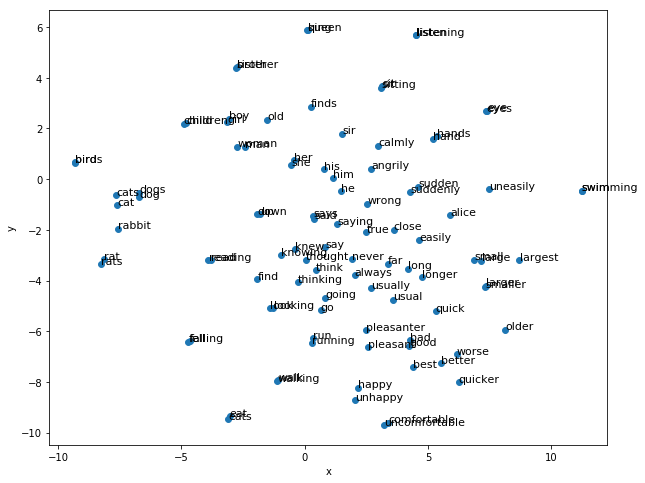

In [63]:
analogies = read_in_anologies()
points = plot_anologies(word2vec, analogies, True)

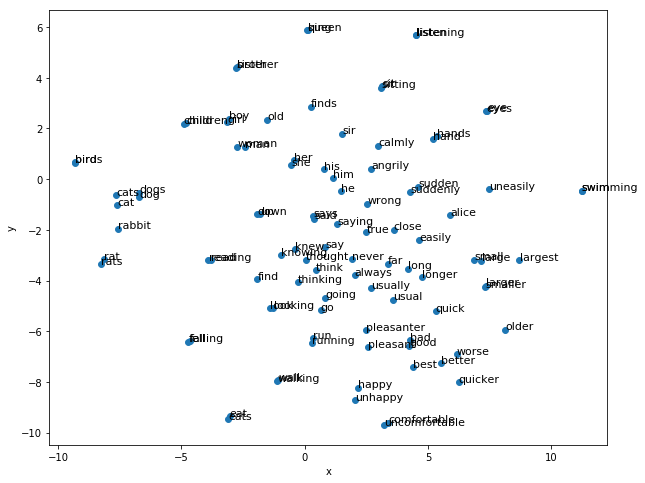

In [64]:
analogies = read_in_anologies()
points = plot_anologies(glove, analogies, True)

# Comparison

As one can see from the visualization of the analogies provided by analogy_alice.txt. The Google dataset and the GloVe dataset perform equally all the words are more or less at the same location. 


In [73]:
file = open('analogy_alice.txt')
lines = file.readlines()
print(len(lines))

46


In [71]:
test_acc(word2vec, True)

(32, 35, 37)

In [72]:
test_acc(glove, True)

(31, 34, 35)

# Comparison of analogy function
First of all we print the amount of analogies that are in analogy_alice.txt which are 46 in total. We ran each pre-defined model using our analogy function. We count the times a result is the top, in the top 5 and in the top 10. For example test_acc(word2vec,True) gives us (32, 35, 37). This means that the expected value was 32 times the top result, 35 times the result was in the top 5 and 37 times the result was in the top 10. (Obviously if a result was the top, it is also in the top 5 and top 10). From this we can conclude that word2vec found 3 expected values in the top 5 and 2 in the top 10. Makiing it pretty accurate. The same can be said from the GloVe dataset. This was expected because the visualisations of the analogies for word2vec and GloVe are more or less the same. Which is far better than our trained models. Futhermore, we can conclude that this is not due to a bug in our analogy method.